In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/coffee-sales/index_2.csv
/kaggle/input/coffee-sales/index_1.csv


In [2]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("ihelon/coffee-sales")

# print("Path to dataset files:", path)

In [3]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "/index_1.csv"

# Load the latest version
df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "ihelon/coffee-sales",
  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())

First 5 records:          date                 datetime cash_type                 card  money  \
0  2024-03-01  2024-03-01 10:15:50.520      card  ANON-0000-0000-0001   38.7   
1  2024-03-01  2024-03-01 12:19:22.539      card  ANON-0000-0000-0002   38.7   
2  2024-03-01  2024-03-01 12:20:18.089      card  ANON-0000-0000-0002   38.7   
3  2024-03-01  2024-03-01 13:46:33.006      card  ANON-0000-0000-0003   28.9   
4  2024-03-01  2024-03-01 13:48:14.626      card  ANON-0000-0000-0004   38.7   

     coffee_name  
0          Latte  
1  Hot Chocolate  
2  Hot Chocolate  
3      Americano  
4          Latte  


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3636 entries, 0 to 3635
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         3636 non-null   object 
 1   datetime     3636 non-null   object 
 2   cash_type    3636 non-null   object 
 3   card         3547 non-null   object 
 4   money        3636 non-null   float64
 5   coffee_name  3636 non-null   object 
dtypes: float64(1), object(5)
memory usage: 170.6+ KB
None


In [5]:
# Convert 'datetime' column to datetime objects
# Assuming 'datetime' contains both date and time (e.g., 'YYYY-MM-DD HH:MM:SS')
df['datetime'] = pd.to_datetime(df['datetime'])

# Convert 'date' column to datetime objects (for consistency, though 'datetime' is primary)
df['date'] = pd.to_datetime(df['date'])

# Ensure 'money' is a numeric type (float or int)
# Use .loc to safely assign the conversion
df.loc[:, 'money'] = pd.to_numeric(df['money'], errors='coerce') 

# Clean 'cash_type' and 'coffee_name' by converting to string/category types
df.loc[:, 'cash_type'] = df['cash_type'].astype('category')
df.loc[:, 'card'] = df['card'].astype('string')
df.loc[:, 'coffee_name'] = df['coffee_name'].str.strip().str.title().astype('category') 

# Drop rows where 'money' or 'datetime' are invalid/missing after conversion
df.dropna(subset=['money', 'datetime'], inplace=True) 

print("\nData types converted and missing values handled.")
print(df.info())


Data types converted and missing values handled.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3636 entries, 0 to 3635
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         3636 non-null   datetime64[ns]
 1   datetime     3636 non-null   datetime64[ns]
 2   cash_type    3636 non-null   object        
 3   card         3547 non-null   object        
 4   money        3636 non-null   float64       
 5   coffee_name  3636 non-null   object        
dtypes: datetime64[ns](2), float64(1), object(3)
memory usage: 170.6+ KB
None


In [6]:
# --- Time-Based Features ---
# 1. Hour of Day (for Peak Sales Analysis)
df.loc[:, 'hour_of_day'] = df['datetime'].dt.hour 

# 2. Day of Week (for operational planning)
# Monday=0, Sunday=6
df.loc[:, 'day_of_week_num'] = df['datetime'].dt.dayofweek 
df.loc[:, 'day_of_week'] = df['datetime'].dt.strftime('%a') # e.g., 'Mon', 'Tue'

# 3. Month and Year (for trend filtering)
df.loc[:, 'month_year'] = df['datetime'].dt.to_period('M')

# --- Transaction Features ---
# 4. Transaction Count (for easy grouping/counting, always equals 1 per row)
df.loc[:, 'transaction_count'] = 1 

# --- Display Final Engineered Features ---
print("\nFeature engineering complete.")
print(df[['datetime', 'hour_of_day', 'day_of_week', 'money']].head())


Feature engineering complete.
                 datetime  hour_of_day day_of_week  money
0 2024-03-01 10:15:50.520           10         Fri   38.7
1 2024-03-01 12:19:22.539           12         Fri   38.7
2 2024-03-01 12:20:18.089           12         Fri   38.7
3 2024-03-01 13:46:33.006           13         Fri   28.9
4 2024-03-01 13:48:14.626           13         Fri   38.7


Global KPIs (ATV, Total Revenue, Total Transactions)

In [7]:
# Calculate core aggregate metrics to spot check the data
total_transactions = df['transaction_count'].sum()
total_revenue = df['money'].sum()
average_price_per_cup = total_revenue / total_transactions

print(f"\nTotal Transactions: {total_transactions:,}")
print(f"Total Revenue (UAH): {total_revenue:,.2f} UAH")
print(f"Average Transaction Value (ATV): {average_price_per_cup:,.2f} UAH")

# Data is now cleaned and prepared for Phase 2: Core KPI Calculation & Analysis.


Total Transactions: 3,636
Total Revenue (UAH): 115,431.58 UAH
Average Transaction Value (ATV): 31.75 UAH


Top-Selling Coffee Types (KPI 2)

In [8]:
# 2. Aggregation by Coffee Type
coffee_performance = df.groupby('coffee_name').agg(
    total_volume=('transaction_count', 'sum'),
    total_revenue=('money', 'sum')
).reset_index()

# Sort by Volume to find Top Sellers
coffee_performance = coffee_performance.sort_values(
    by='total_volume', ascending=False
).head(10) # Get Top 10 for detailed analysis

# Calculate Average Price per Cup for each coffee
coffee_performance['avg_price'] = (
    coffee_performance['total_revenue'] / coffee_performance['total_volume']
)

print("\n--- Top 10 Coffee Performance (Sorted by Volume) ---")
print(coffee_performance.head(3))


--- Top 10 Coffee Performance (Sorted by Volume) ---
           coffee_name  total_volume  total_revenue  avg_price
1  Americano With Milk           824       25269.12  30.666408
7                Latte           782       27866.30  35.634655
0            Americano           578       15062.26  26.059273


Payment Method Split (KPI 3)

In [9]:
# 3. Aggregation by Payment Type (Cash vs. Card)
payment_split = df.groupby('cash_type').agg(
    transactions=('transaction_count', 'sum'),
    revenue=('money', 'sum')
).reset_index()

# Calculate % of transactions
total_transactions = payment_split['transactions'].sum()
payment_split['transaction_percentage'] = (
    payment_split['transactions'] / total_transactions
)

print("\n--- Payment Method Split ---")
print(payment_split)


--- Payment Method Split ---
  cash_type  transactions    revenue  transaction_percentage
0      card          3547  112245.58                0.975523
1      cash            89    3186.00                0.024477


Peak Sales Hour

In [10]:
# 4a. Hourly Sales Trend (The Single Most Efficient Detail)
hourly_trend = df.groupby('hour_of_day').agg(
    hourly_volume=('transaction_count', 'sum'),
    hourly_revenue=('money', 'sum')
).reset_index()

# Identify the peak hour
peak_hour_data = hourly_trend.sort_values(
    by='hourly_volume', ascending=False
).iloc[0]

print("\n--- Hourly Sales Trend (Peak Hour Insight) ---")
print(f"Peak Sales Hour (by volume): {peak_hour_data['hour_of_day']} o'clock")
print(hourly_trend.head())


# 4b. Day of Week Sales Trend
# Note: Use the 'day_of_week_num' from Phase 1 to ensure correct ordering (Mon=0)
day_of_week_trend = df.groupby(['day_of_week_num', 'day_of_week']).agg(
    daily_volume=('transaction_count', 'sum'),
    daily_revenue=('money', 'sum')
).reset_index().sort_values(by='day_of_week_num') # Ensure Mon-Sun order

print("\n--- Day of Week Sales Trend ---")
print(day_of_week_trend)


--- Hourly Sales Trend (Peak Hour Insight) ---
Peak Sales Hour (by volume): 10.0 o'clock
   hour_of_day  hourly_volume  hourly_revenue
0            6              5          149.40
1            7             91         2940.02
2            8            235         7017.88
3            9            247         7429.28
4           10            349        10994.52

--- Day of Week Sales Trend ---
   day_of_week_num day_of_week  daily_volume  daily_revenue
0                0         Mon           561       17925.10
1                1         Tue           585       18637.38
2                2         Wed           510       16093.46
3                3         Thu           520       16477.40
4                4         Fri           544       17257.66
5                5         Sat           482       15182.52
6                6         Sun           434       13858.06


In [11]:
# Export aggregated data for use in the BI tool
coffee_performance.to_csv('coffee_performance.csv', index=False)
payment_split.to_csv('payment_split.csv', index=False)
hourly_trend.to_csv('hourly_sales_trend.csv', index=False)
day_of_week_trend.to_csv('day_of_week_sales_trend.csv', index=False)

print("\nAll aggregated data exported successfully to CSV files.")


All aggregated data exported successfully to CSV files.


Top 5 Coffee Performance (Marketing Insight)

In [12]:
coffee_performance.head()

,coffee_name,total_volume,total_revenue,avg_price
1,Americano With Milk,824,25269.12,30.666408
7,Latte,782,27866.30,35.634655
0,Americano,578,15062.26,26.059273
2,Cappuccino,501,18034.14,35.996287
4,Cortado,292,7534.86,25.804315


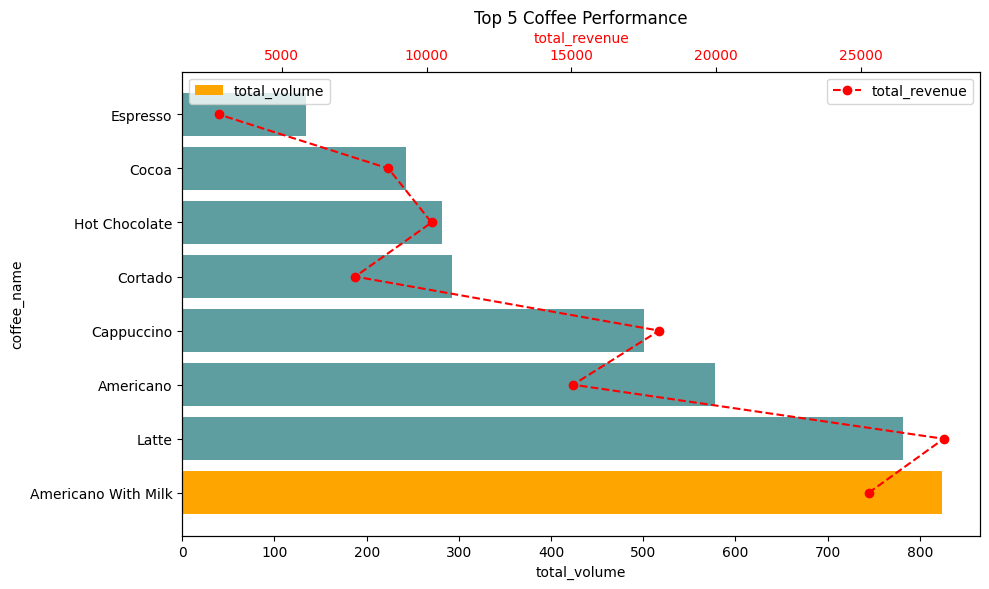

In [13]:
# categories = ['Category A', 'Category B', 'Category C', 'Category D']
# values1 = [10, 25, 15, 30]
# values2 = [100, 250, 150, 300] # Secondary axis values

import matplotlib.pyplot as plt

# Data for the chart
# coffee_performance
categories = coffee_performance['coffee_name']
values1 = coffee_performance['total_volume']
values2 = coffee_performance['total_revenue']

fig, ax1 = plt.subplots(figsize=(10, 6))

y_pos = np.arange(len(categories))
ax1.barh(y_pos, values1, color=np.where(values1 == values1.max(),'orange','cadetblue'), label='total_volume')
# ax1.barh(y_pos, values1, color=c, label='total_volume')
ax1.set_yticks(y_pos)
ax1.set_yticklabels(categories)

ax2 = ax1.twiny() # Create a twin y-axis sharing the x-axis


# Plot secondary data (e.g., as a line or another bar set)
ax2.plot(values2, categories, color='red', marker='o', linestyle='--', label='total_revenue')

# Set labels and title
ax1.set_xlabel('total_volume')
ax1.set_ylabel('coffee_name')
ax2.set_xlabel('total_revenue', color='red')
ax2.tick_params(axis='x', labelcolor='red')
plt.title('Top 5 Coffee Performance')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

Peak Sales Hour Analysis (The Single Most Efficient Detail)